# <h1><center><strong>$$\color{#4740BF}{\text{4. Bert for MultiClass Text Classification}}$$<strong>
  

### <h1><center><strong>$$\color{#4740BF}{\text{Useful libraries}}$$<strong>


In [ ]:
%%capture
!pip install transformers
!pip install wandb
!pip install pytorch-pretrained-bert==0.4.0
!pip install --upgrade tqdm

In [ ]:
# Importing the libraries needed
%%capture
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [ ]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

### <h1><center><strong>$$\color{#4740BF}{\text{Import the data}}$$<strong>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/progetto text mining/CSV/new_train2.csv')
test = pd.read_csv('/content/drive/MyDrive/progetto text mining/CSV/new_test2.csv')

In [ ]:
train.isnull().sum()
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)
train.isnull().sum()

test.isnull().sum()
test.dropna(inplace=True)
test.reset_index(drop=True, inplace=True)
test.isnull().sum()

frames = [train, test]
df = pd.concat(frames, ignore_index = True)
print(test.isnull().sum())

label     0
review    0
dtype: int64


We split the original dataset in 3 categories, since we  expect that with this new categories the result would be better, as proved in the previous models.
The new categories are:
- positive reviews (label = 4 or 5), that are represented with *cat*=2
- neutral reviews (label = 3), that are represented with *cat*=1
- negative reviews (label = 0 or 1), that are represented with *cat*=0

We also balanced the new dataframe so that the numbers of positive, negative and neutral reviws are similar.

In [ ]:
#Creating the new categories 
df["cat"] = df["label"]
df["cat"].replace({1: 0, 2: 0, 3: 1, 4: 2, 5: 2}, inplace=True)
del df["label"]

#Balancing the classes
from sklearn.utils import shuffle
pos_df_subset = df[df["cat"]==2].sample(n=len(df[df["cat"]==1]),random_state=28)
neut_df_subset = df[df["cat"]==1]
neg_df_subset = df[df["cat"]==0].sample(n=len(df[df["cat"]==1]),random_state=98)
df_sub = shuffle(pd.concat([pos_df_subset, neut_df_subset, neg_df_subset], ignore_index = True))
df_sub.reset_index(drop=True, inplace=True)

Since the following model is very computationally expensive, in order to being able to run the code in a reasonable ammount of hours, we analyzed only a subsample of the original dataset.

In [ ]:
#Taking a subsample of the dataset
df = df_sub.sample(n=int(df_sub.shape[0])//10,random_state=8)
df.reset_index(drop=True, inplace=True)
df["cat"].value_counts()

0    14102
1    14078
2    13818
Name: cat, dtype: int64

### <h1><center><strong>$$\color{#4740BF}{\text{Create the Dataloader}}$$<strong>

Let's define some variables that will be used later in the training. 

We used a small learning rate and a small batch size to have higher accuracy. 
The `MAX_LEN` parameter, that represents the max numbers of tokens for each review, is 160 i.e. the 95 percentile of the reviews length.
As tokenizer, we used DistilBert, which is a smaller and faster version of Bert. We used the base-cased version of DistilBert where the text is same as the input text (the text has not been lowercased before tokenization step).

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 160
TRAIN_BATCH_SIZE = 4
TEST_BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 1e-05  
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

To process our dataset we transform it into a *Triage* class. This dataset class takes as input the dataset and then tokenize the review so that DistilBERT can use these tokens for training. The method used to tokenize is `encode_plus` that returns a dictionary containing the encoded sequence (`ids`) and the mask for sequence classification (`attention_mask`). The `attention_mask` indicates to the model which tokens should be attended to, and which should not.
Then we transform our dataset into a *Triage* class and we split the dataset into training and testing (20% of the entire dataset).


In [ ]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        Review = str(self.data.review[index])    
        Review = " ".join(Review.split())
        inputs = self.tokenizer.encode_plus(
            Review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.cat[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

Let's define the Dataloader that will feed  the data in batches to the neural network.
Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, so the amount of dataloaded to the memory and then passed to the neural network needs to be controlled using parameters such as `batch_size` and `max_len`. Dataloader is a construct of PyTorch library.

In [ ]:
# Creating the dataset and dataloader for the neural network
train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=2)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (41998, 2)
TRAIN Dataset: (33598, 2)
TEST Dataset: (8400, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

### <h1><center><strong>$$\color{#4740BF}{\text{Training the model}}$$<strong>

Now we will create a neural network with the `DistillBERTClass`.  The network will be made up of a the DistilBERT Language model, a `dropout` and a `Linear` layer to obtain the final outputs. 

The DistilBERT Language model has 40% less parameters than bert-base-uncased and therefore runs 60% faster. In out specific case we use pertained DistilBERT Base model that has 6 hidden layers in the Transformer encoder, 12  attention heads for each attention layer and an  encoder layers with dimension 768. 

The output layer is a linear layer with 3 neurons that correspond to the 3 categories (POS=2, NEU=1, NEG=0). To avoid overfitting we set a large dropout equal to 0.7. We initiated an instance of the network `model` that will be used for training.
 

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.7)         
        self.classifier = torch.nn.Linear(768, 3)    

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)     
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = DistillBERTClass()
model.to(device)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

Here we define the `Loss Function` and `Optimizer`. 
The `Loss Function` is used the calculate the difference in the output created by the model and the actual output. We use the cross entropy loss function since we are doing a classification task. The `Optimizer` is used to update the weights of the neural network to improve its performance.

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

Finally, after creating the model, we can train the model on the training dataset. We specify the number of epochs: an epoch defines how many times the complete data will be passed through the network. 

The `train` function works in the following way: first of all the dataloader passes data to the model based on the batch size, then subsequent output from the model and the actual category are compared to calculate the loss. The loss value is important because it is used to optimize the weights of the neurons in the network. 

In the `train` function we added two lists, in which we save the accuracy and the loss of the model on the training dataset. These lists are useful for plotting graphs later on.

In [ ]:
# Function to calcuate the accuracy of the model
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
train_accu = []
train_loss = []

def train(epoch):
    print('\nEpoch : %d'%epoch)
    
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
       
        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        optimizer.zero_grad()
        loss.backward()
        # When using GPU
        optimizer.step()
        #print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    train_accu.append(epoch_accu)
    train_loss.append(epoch_loss)
  

    return train_accu, train_loss

Finally, we fit the model for the different epochs. 

In case the function `train` stopped improving greatly the accuracy of the model after some epochs, we want to stop it. For this reason we added a stop value: `Early_stopping_value` stops the running of the model when the accuracy improves less then 0,1%.


In [ ]:
%%time
Early_stopping_value = 0.001

for epoch in range(EPOCHS):
  train(epoch)
  if epoch >= 1:
    if abs(train_accu[epoch] - train_accu[epoch-1]) < Early_stopping_value:
      print("\nEarly stopping. Epoch:", epoch)
      break 
  


Epoch : 0


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


The Total Accuracy for Epoch 0: 57.32781713197214
Training Loss Epoch: 0.8714129436362003
Training Accuracy Epoch: 57.32781713197214

Epoch : 1
The Total Accuracy for Epoch 1: 69.04577653431753
Training Loss Epoch: 0.6908467469078355
Training Accuracy Epoch: 69.04577653431753

Epoch : 2
The Total Accuracy for Epoch 2: 74.63539496398595
Training Loss Epoch: 0.5858401621120893
Training Accuracy Epoch: 74.63539496398595

Epoch : 3
The Total Accuracy for Epoch 3: 80.70420858384428
Training Loss Epoch: 0.47077420626822414
Training Accuracy Epoch: 80.70420858384428

Epoch : 4
The Total Accuracy for Epoch 4: 85.90689922019168
Training Loss Epoch: 0.35441752491015777
Training Accuracy Epoch: 85.90689922019168

Epoch : 5
The Total Accuracy for Epoch 5: 90.36549794630633
Training Loss Epoch: 0.2556209166334399
Training Accuracy Epoch: 90.36549794630633

Epoch : 6
The Total Accuracy for Epoch 6: 93.48770760164295
Training Loss Epoch: 0.17881772066004314
Training Accuracy Epoch: 93.48770760164295


After running the model, we noticed that the accuracy grows very fast, and we were able to reach a very high accuracy in the last epoch: 97%!

In the following graphs we can see the changes in the accuracy and loss of the model. 

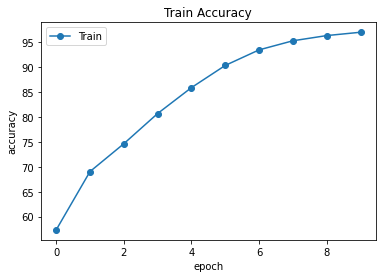

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image

display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.plot(train_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train'])
plt.title('Train Accuracy')
 
plt.show()

From this plot we can notice the fast growing of the accuracy of the model. After some epochs the improvemnt starts to stabilize. 

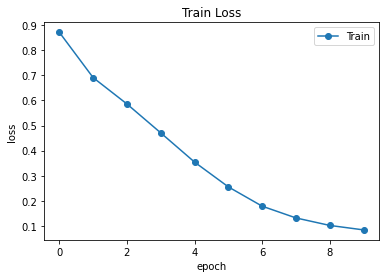

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.plot(train_loss,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train'])
plt.title("Train Loss")
 
plt.show()

From this plot we can notice the fast decreasing trend of the loss of the model. 

In [ ]:
# Saving the MODEL in files for re-use

output_model_file = '/content/drive/MyDrive/Colab Notebooks/trans_cat.torch'
output_vocab_file = '/content/drive/MyDrive/Colab Notebooks/vocab_distilbert_news.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')

All files saved


### <h1><center><strong>$$\color{#4740BF}{\text{Testing the model}}$$<strong>

We will now test the model on some data that was not seen by the model, the Testing Dataset.

In the following function we compute the prediction probabilities (by applying the softmax on the model outputs) and the predicted categories. The functions returns the text of the review, the predictions probabilities and the predicted category, and finally the actual category of the review. 
It is important to notice that during the testing stage the weights of the model are not updated. 



In [ ]:
import torch.nn.functional as F

def get_predictions(model, testing_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in testing_loader:

      texts = test_dataset["review"]      
      input_ids = d["ids"].to(device)
      attention_mask = d["mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions( model, testing_loader)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Let's look at the results of the `get_predictions` function on the first review of the training dataset. 

In [ ]:
print(y_review_texts[i],"\n", y_pred[i],"\n", y_pred_probs[i],"\n", y_test[23])

olive awesome products new wonderful try recently purchase sent home flying home board plane package sent business day said showed door fed ex lost taken porch packages delivered time problem fed ex failed track closed case soon reported olive guarantee shipments sent package delay happy service mention package received super good spanish olive tapanade white truffle oil limited edition peach white balsamic glaze oh wait use queen creek sure stop sample lots fun shop 
 tensor(2) 
 tensor([0.1259, 0.3736, 0.5005]) 
 tensor(1)


Let's have a look at the classification report.

In [ ]:
from sklearn.metrics import classification_report 

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      2742
           1       0.57      0.53      0.55      2856
           2       0.70      0.73      0.71      2802

    accuracy                           0.66      8400
   macro avg       0.66      0.66      0.66      8400
weighted avg       0.66      0.66      0.66      8400



We can see the model is predicting the correct category of a given review to a 66% of accuracy.
The accuracy is way smaller than the accuracy of the training step: that is probably due to an overfitting of the model and to the fact that we used a subsample of the dataset.

As we would expect, it looks like it is harder to classify neutral (category = 1) reviews. 

We'll continue with the confusion matrix:

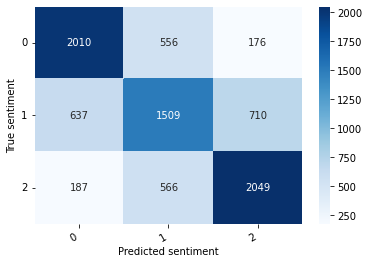

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

 As in prevoius models, the false positves and false negatives usually occur for "contiguos categories" ie the algorithm usually do not confuse negative and positive reviews but only negative and neutral or neutral and positive.



# <h1><center><strong>$$\color{#4740BF}{\text{5. Conclusions}}$$<strong>

Considering the results obtained with the dataframe with 5 categories we got an accuracy of 56% with the Linear SVC with a time to train the model equal to 3 minutes and 58 seconds. On the other hand the Bi-LSTM got an accuracy of 60% with a running time of around 15 hours. It is clear that even if with the second method we get an higher accuracy the running time is too much longer. 

As regards the dataframe with only 3 categories we were able to get better results:


*   Linear SVC: accuracy of 72% with a running time for training the model approximately equal to 2 minutes
*   Bi-LSTM: accuracy of 76% with a running time for training the model approximately equal to 7 hours and 20 minutes. However, in this case it would be better to look at the precision metrics since we didn't balanced the testing dataset. The weighted precision was 80%
*   DistillBert:  accuracy of 66% with a running time for training the model approximately equal to 3 hours and 20 minutes. 

As we explained before the quite-low level of accuracy of DistillBert model is due to the fact that our model overfitt the training dataset. In fact, we got an accuracy on the training set equal to 97%. It is anyway important to take into account that the final model was trained on a far smaller dataset and certatly this has an impact on the final results. 

To conclude, without a powerful machine the machine learning algorithms seems to be the best choice, anyway we are sure that with more time and more powerful computers we could get very precise results with Neural Network approach, most of all DistillBert that was able to get astonished results in few epochs. 




